In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'figure.figsize': (3.5, 3),
    'font.cursive': ['Helvetica-Oblique'],
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Helvetica'],
    'font.size': 8,
    'legend.fontsize':8,
    'lines.linewidth': 1,
    'lines.markersize': 2.5,
    'pdf.fonttype': 42,
    'xtick.labelsize':8, #12
    'xtick.major.size':2,
    'ytick.labelsize':8, # 12
    'ytick.major.size':2,
})


def read_logfile(filepath, delim=' '):
    """Read log file from feedback controller
    
    Parameters:
    -----------
    filepath : str
        path to log file
    
    Returns:
    --------
    logdict : dict
        mapping from variable names in log file to numpy arrays
        containing their data
    """
    def extract_var(loglines, var:str):
        """Extract column data and return as numpy array"""
        col = loglines[0].index(var)
        data = [line[col] for line in loglines[1:]]
        dtype = int if var in ['Timestamp','int_weight'] else float
        if dtype == float:
            data = [d.replace(',','.') for d in data]
        return np.array(data, dtype)
    
    with open(filepath) as f:
        loglines = [line.rstrip(' \n').split(delim) for line in f.readlines()]  
        
    return {k:extract_var(loglines,k) for k in loglines[0]}


def linearfit(x,y,skip=10):
    """Fit y=ax+b, skipping the first 'skip' values
    
    Parameters:
    -----------
    x, y : array-like
        x and y-values of data to fit
    skip : int
        number of entries to skip on x and y

    Returns:
    --------
    (xfit, yfit) : tuple of arrays
        x and y-values of fit
    (a, b) : tuple of int
        linear regression coefficients
    """
    xfit = x[skip:]
    a,b = np.polyfit(xfit,y[skip:],1)
    yfit = a*xfit + b
    return (xfit,yfit), (a,b)

reading ./ControlLog_b.e21.BSSP585cmip6.f09_g17.2020feedback.02.2020-2100.txt
applied feedforward: kff: 0.00362, t0: 2000
fitting years [2030 - 2100]
fit results: kff_fit = 0.008282393525532889, t0_fit = 2019.5862876462286
correlation of fit with data: 0.9977229885314651
saving ControlLog_b.e21.BSSP585cmip6.f09_g17.2020feedback.02.2020-2100.pdf


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


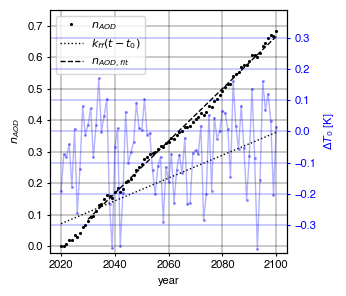

In [2]:
LOGFILE = './ControlLog_b.e21.BSSP585cmip6.f09_g17.2020feedback.02.2020-2100.txt'
kff = 0.00362 # applied feedforward constant kff
t0 = 2000  # applied feedforward base year
x = 'Timestamp' # x-axis variable
y1 = 'L0'; c = 'k'; ylim = [-0.02,0.75] # properties of left y-axis variable
y2 = 'dT0'; c2 = 'b'; ylim2 = [-0.39, 0.39] # properties of right y-axis variable
nskip = 10 # number of years to skip when fitting y1 data
ext = '.pdf' # figure save format

ds = read_logfile(LOGFILE)
logname = os.path.splitext(os.path.basename(LOGFILE))[0]
print("reading", LOGFILE)
print(f"applied feedforward: kff: {kff}, t0: {t0}")

# fit n_aod
fit, coef = linearfit(ds[x],ds[y1], skip=nskip)
baseyear = fit[0][0] - fit[1][0]/coef[0]
r = np.corrcoef(fit[1],ds[y1][nskip:])[1,0]
print(f"fitting years [{ds[x][nskip]} - {ds[x][-1]}]")
print(f"fit results: kff_fit = {coef[0]}, t0_fit = {baseyear}")
print(f"correlation of fit with data: {r}")

# y plot (n_aod)
fig = plt.figure()
ax = fig.gca()
ax.plot(ds[x], ds[y1],'.', c=c, label=r'$n_{AOD}$')
ax.set_xlabel('year')
ax.set_ylabel(r'$n_{AOD}$', c=c)
ax.set_ylim(ylim)
ax.grid(c=c, axis='both', lw=.3)
ax.tick_params(axis='y', color=c, labelcolor=c)

# fit plots
p1=ax.plot(ds[x], kff*(ds[x]-t0), ':', c=c,label=r'$k_{ff}(t-t_{0})$')
ax.plot(*(fit),'--', c=c,label=(r'$n_{AOD,fit}$'))
# ax.text(2053,0.56,r'$k_{ff}$'+f' = {kff}\n'+r'$t_0$'+f' = {t0}\n'+r'$k_{ff,fit}$'
#         +f' = {coef[0]:0.5f} \n'+r'$t_{0,fit}$'+f' = {baseyear:0.2f})')
ax.legend(loc='upper left')

# y2 plot (dT)
ax2 = ax.twinx()
p2 = ax2.plot(ds[x], ds[y2], '.-', c=c2, label=r'$\DeltadT_0$',alpha=0.3)
ax2.set_ylabel(r'$\Delta T_0$ [K]',c=c2)
ax2.grid(axis='y', c=c2, lw=.3)
ax2.tick_params(axis='y', color=c2, labelcolor=c2)
ax2.set_ylim(ylim2)

fig.tight_layout()
print(f"saving {logname+ext}")
fig.savefig(logname+ext, dpi=300, transparent=False)
plt.show()

saving ControlLog_b.e21.BSSP585cmip6.f09_g17.2020feedback.02.2020-2100.allvars.pdf


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


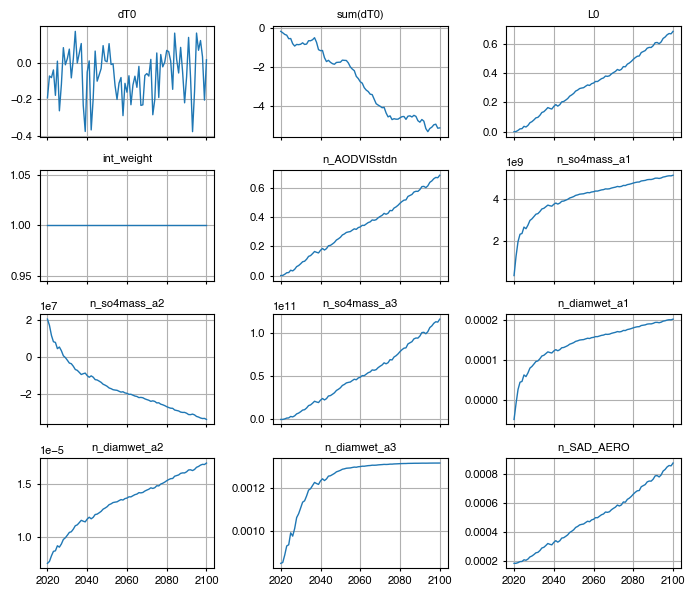

In [3]:
fig, ax = plt.subplots(4,3, sharex=True, figsize=(7,6))
cols = list(ds.keys())
for i,axi in enumerate(ax.flatten()):
    axi.plot(ds['Timestamp'], ds[cols[i+1]])
    axi.set_title(cols[i+1])
    axi.grid()
fig.tight_layout()
print(f"saving {logname+'.allvars'+ext}")
fig.savefig(logname+'.allvars'+ext, dpi=300, transparent=False)
plt.show()